# Home Price Index Prediction

## package and utility functions

In [1]:
! pip install shap
! pip install fredapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 2.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from functools import partial
import dateutil.relativedelta
from typing import Tuple
from typing import List

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
import shap

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

from fredapi import Fred
fred = Fred(api_key='40c4b75792c41c12261e246c7c1f43f3')

In [3]:
import warnings
from warnings import simplefilter

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [4]:
def get_target():
    target = fred.get_series('CSUSHPINSA').to_frame()
    target.index.names = ['month']
    # variables that start with 'target' are future values, should not be used in features
    target.columns = ['target_HPI']
    target['target_HPI_chg'] = target['target_HPI'].pct_change()
    target['target_HPI_chg_diff'] = target['target_HPI_chg'].diff(1)
    target = target.shift(-1)
    start_date = target[pd.isnull(target).any(axis=1) == False].index[0]
    end_date = target[pd.isnull(target).any(axis=1) == False].index[-1]
    target = target[(target.index >= start_date) & (target.index <= end_date)]
    return target


def get_data(FRED_key: str, col_name: str, target_index: pd.DatetimeIndex, func = None) -> pd.Series:
    # get data
    data = fred.get_series(FRED_key)
    # apply transformation
    if func is not None:
        data = func(data)

    data.name = col_name

    # match index
    target_index = list(target.index)
    for m in range(1, 14):
        target_index.append(target.index[0] - dateutil.relativedelta.relativedelta(months=m)) # for building rolling features or lagging features
    target_index = sorted(target_index)
    combine_index = sorted(set(list(target_index)+list(data.index)))
    data = data.reindex(combine_index)

    # fill nan
    data = data.ffill()
    return data.loc[target_index]


def chg(base: pd.Series, hzn: int=1, col_name=None)->pd.Series:
    feature_chg = base/base.shift(hzn)-1
    if col_name is not None:
        feature_chg.name = col_name
    return feature_chg


def ewma(base: pd.Series, hzn: int=1, col_name=None)->pd.Series:
    feature_ewma = base.ewm(halflife=hzn).mean()
    if col_name is not None:
        feature_ewma.name = col_name
    return feature_ewma


def ewm_std(base: pd.Series, hzn: int=1, col_name=None)->pd.Series:
    feature_ewma = base.ewm(halflife=hzn).mean()
    feature2_ewma = (base**2).ewm(halflife=hzn).mean()
    result = pd.Series(np.sqrt(feature2_ewma - feature_ewma**2), index=base.index)
    if col_name is not None:
      result.name = col_name
    return result


def clip_features(features: pd.DataFrame, col_name: str, lower: float=None, upper: float=None)->None:
    if lower is not None:
        lower = np.quantile(features[col_name].dropna(), lower)
    if upper is not None:
        upper = np.quantile(features[col_name].dropna(), upper)
    features[col_name] = features[col_name].clip(lower=lower, upper=upper)
    return


def fill_abnormal_by_mean(train_x: pd.DataFrame, test_x: pd.DataFrame)->Tuple[pd.DataFrame, pd.DataFrame]:
    train_x.fillna(train_x.mean(), inplace=True)
    to_replace = {col:[np.inf, -np.inf] for col in train_x.columns}
    train_x = train_x.replace(to_replace, train_x.mean().to_dict())

    test_x.fillna(train_x.mean(), inplace=True)
    test_x = test_x.replace(to_replace, train_x.mean().to_dict())
    return train_x, test_x


def rolling_windows(X: pd.DataFrame, Y: pd.DataFrame, min_training_data: int, max_training_data: int, rolling_freq: int)->Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if (X.index != Y.index).any():
        raise ValueError("Indices of X and Y do not match.")

    train_end = min_training_data
    while train_end < X.shape[0]:
        train_start = max(train_end - max_training_data, 0)
        test_start = train_end
        test_end = min(test_start + rolling_freq, X.shape[0])
        train_x = X.iloc[train_start:train_end]
        train_y = Y.iloc[train_start:train_end]
        test_x = X.iloc[test_start:test_end]
        test_y = Y.iloc[test_start:test_end]

        # some features are not available yet, we need to drop it
        threshold = int(train_x.shape[0]/3)
        features_nan = pd.isnull(train_x[:threshold]).all(axis=0)
        keep_cols = features_nan[~features_nan].index
        train_x = train_x[keep_cols]
        test_x = test_x[keep_cols]

        yield train_x, train_y, test_x, test_y
        train_end += rolling_freq


def rolling_windows_wvalid(X: pd.DataFrame, Y: pd.DataFrame, min_training_data: int, max_training_data: int, train_valid_ratio: float, rolling_freq: int)->Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if (X.index != Y.index).any():
        raise ValueError("Indices of X and Y do not match.")

    valid_end = min_training_data
    while valid_end < X.shape[0]:
        train_start = max(valid_end - max_training_data, 0)
        valid_len = int((valid_end - train_start)*train_valid_ratio)
        valid_start = valid_end - valid_len
        test_end = min(valid_end + rolling_freq, X.shape[0])
        train_x = X.iloc[train_start:valid_start]
        valid_x = X.iloc[valid_start:valid_end]
        test_x = X.iloc[valid_end:test_end]
        train_y = Y.iloc[train_start:valid_start]
        valid_y = Y.iloc[valid_start:valid_end]
        test_y = Y.iloc[valid_end:test_end]

        # some features are not available yet, we need to drop it
        threshold = int(train_x.shape[0]/3)
        features_nan = pd.isnull(train_x[:threshold]).all(axis=0)
        keep_cols = features_nan[~features_nan].index
        train_x = train_x[keep_cols]
        valid_x = valid_x[keep_cols]
        test_x = test_x[keep_cols]

        yield train_x, train_y, valid_x, valid_y, test_x, test_y
        valid_end += rolling_freq


def build_XY(features: pd.DataFrame, target: pd.DataFrame)->pd.DataFrame:
    return pd.concat([features.loc[target.index], target], axis=1)


def get_metric(preds: pd.DataFrame, true_labels: pd.DataFrame, stgy_name: str)->pd.DataFrame:
    df = pd.concat([preds, true_labels], axis=1)
    df.columns = ['pred', 'true']
    df['pred'] = df['pred'].fillna(0)
    MAE = mean_absolute_error(df['pred'], df['true'])
    RMSE = mean_squared_error(df['pred'], df['true'], squared=False)
    corr = df.corr().iloc[0, 1]
    df = pd.DataFrame({'MAE': MAE,
                       'RMSE': RMSE,
                       'Corr': corr}, index=[stgy_name])
    return df


def plot_pred(preds: pd.DataFrame, target: pd.DataFrame, stgy_name: str)->None:
    df = pd.concat([preds, target], axis=1)
    df.columns = ['y_pred', 'y_true']
    df = df[df.index > preds.index[0]]
    fig = px.line(df, x=df.index, y=df.columns[:], title = f"stgy: {stgy_name}")
    fig.update_layout(
        font=dict(
            size=18,
            )
    )
    fig.show()
    return


def get_HPI_chg_pred(delta_HPI_chg_preds: pd.DataFrame)->pd.DataFrame:
    HPI_chg_pred = delta_HPI_chg_preds + get_data('CSUSHPINSA', 'HPI_chg', target.index, chg).loc[delta_HPI_chg_preds.index]
    return HPI_chg_pred


def performance(preds: pd.DataFrame, stgy_name: str, delta: bool)->pd.DataFrame:
    '''
    delta = True: preds is the predicted delta HPI change
    delta = False: preds is the predicted HPI change
    '''
    target = get_target()
    if delta:
        preds = get_HPI_chg_pred(preds)
    HPI_chg_true = target.loc[preds.index, 'target_HPI_chg']
    df_HPI_chg = get_metric(preds, HPI_chg_true, stgy_name)
    plot_pred(preds, HPI_chg_true, stgy_name)
    return df_HPI_chg


def train_OLS(train_x: pd.DataFrame, train_y: pd.DataFrame, const: bool)->sm.regression.linear_model.RegressionResults:
    if const:
        train_x = sm.add_constant(train_x)
    model = sm.OLS(train_y, train_x)
    result = model.fit()
    return result


def predict_OLS(model: sm.regression.linear_model.RegressionResults, test_x: pd.DataFrame, const: bool)->pd.DataFrame:
    if const:
        test_x = sm.add_constant(test_x, has_constant='add')
    return model.predict(test_x)


def train_OLS_reg(train_x: pd.DataFrame, train_y: pd.DataFrame, const: bool, alpha: float):
    if const:
        train_x = sm.add_constant(train_x)
    model = sm.OLS(train_y, train_x)
    result = model.fit_regularized(alpha=alpha, L1_wt=0)
    return result


def conduct_PCA(train_x: pd.DataFrame, test_x: pd.DataFrame, ratio: float)->Tuple[pd.DataFrame, pd.DataFrame]:
    scaler = StandardScaler()
    scaler.fit(train_x)
    train_x_transform = scaler.transform(train_x)
    test_x_transform = scaler.transform(test_x)

    pca = PCA()
    pca.fit(train_x_transform)
    explained = pca.explained_variance_ratio_.cumsum()
    n_components = len(explained[explained < ratio])
    pca = PCA(n_components=n_components)
    pca.fit(train_x_transform)
    train_x_transform = pd.DataFrame(pca.transform(train_x_transform), index = train_x.index)
    test_x_transform = pd.DataFrame(pca.transform(test_x_transform), index = test_x.index)
    return train_x_transform, test_x_transform


def one_hot(data: pd.DataFrame, categorical_var: List[str])->pd.DataFrame:
    for col in categorical_var:
        dummies = pd.get_dummies(data[col], drop_first=True)
        data = data.drop(columns = col)
        dummies_cols = [f'{col}_{i}' for i in dummies.columns]
        data[dummies_cols] = dummies
    return data


def remove_outliers(train_x: pd.DataFrame, test_x: pd.DataFrame)->Tuple[pd.DataFrame, pd.DataFrame]:
    for col in train_x.columns:
        if (col!='month') & (col!='quarter'):
          lower = np.quantile(train_x[col].dropna(), 0.01)
          upper = np.quantile(train_x[col].dropna(), 0.99)
          train_x[col] = train_x[col].clip(lower=lower, upper=upper)
          test_x[col] = test_x[col].clip(lower=lower, upper=upper)
    return train_x, test_x


def linear_model_feature_selection(model: sm.regression.linear_model.RegressionResults)->Tuple[bool, List[str]]:
    t_stat = model.params/model.HC0_se
    selected_features = t_stat[np.abs(t_stat) > 1.95].index.to_list()
    if 'const' in selected_features:
        add_const = True
        selected_features = [i for i in selected_features if i!= 'const']
    else:
        add_const = False
    return add_const, selected_features


def get_lgbm_params()->dict:
    params = {
        "objective": "mse",
        "n_estimators": 300,
        "num_leaves": 32,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "learning_rate": 0.05,
        'max_depth': 3,
        "verbosity": -1,
        "importance_type": "gain",
        "random_state": 0,
    }
    return params


def calc_rmse_gain(model: lgb.LGBMRegressor, valid_x: pd.DataFrame, valid_y: pd.DataFrame) -> pd.DataFrame:
    explainer = shap.TreeExplainer(model)
    shap_value = explainer.shap_values(valid_x)
    shap_value = pd.DataFrame(shap_value, columns=valid_x.columns)
    y_pred = model.predict(valid_x)
    rmse_old = np.sqrt(np.nanmean(np.square(y_pred - valid_y)))  # with the verse
    y_pred_new = y_pred.reshape((-1, 1)) - shap_value
    rmse_new = np.sqrt(np.nanmean(np.square(y_pred_new - valid_y.values.reshape((-1, 1))), axis=0))  # without the verse
    rmse_increase = pd.DataFrame(rmse_new-rmse_old, columns=['increase'], index=valid_x.columns).sort_values('increase')
    return rmse_increase


## data analysis

In [5]:
target = get_target()

In [6]:
fig = make_subplots(rows=3)
fig.add_scatter(x=target.index, y=target['target_HPI'], row=1, col=1, name='target_HPI')
fig.add_scatter(x=target.index, y=target['target_HPI_chg'], row=2, col=1, name = 'target_HPI_chg')
fig.add_scatter(x=target.index, y=target['target_HPI_chg_diff'], row=3, col=1, name = 'target_HPI_chg_diff')
fig.update_layout(height=600, width=1000, title_text="Target Home Price Index (One Month Ahead)", font_size=16)

**Unit root test of HPI and HPI change**

In [7]:
result_HPI = adfuller(target['target_HPI'])
result_HPI_chg = adfuller(target['target_HPI_chg'])
result_HPI_chg_diff = adfuller(target['target_HPI_chg_diff'])

print('ADF Statistic of HPI: %f' % result_HPI[0], ', p-value: %f' % result_HPI[1])
print('ADF Statistic of HPI change: %f' % result_HPI_chg[0], ', p-value: %f' % result_HPI_chg[1])
print('ADF Statistic of HPI change diff: %f' % result_HPI_chg_diff[0], ', p-value: %f' % result_HPI_chg_diff[1])
print('Critical Values:')
for key, value in result_HPI_chg[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic of HPI: 1.579100 , p-value: 0.997793
ADF Statistic of HPI change: -3.559045 , p-value: 0.006594
ADF Statistic of HPI change diff: -4.983818 , p-value: 0.000024
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


**ACF and PACF plots**

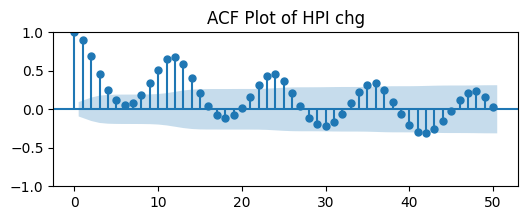

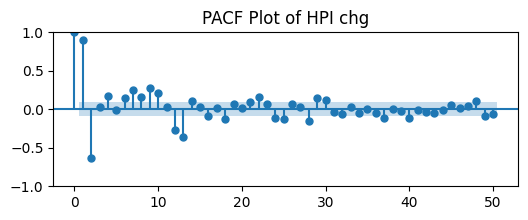

In [8]:
f_acf = plot_acf(target['target_HPI_chg'], lags=50, title='ACF Plot of HPI chg')
f_pacf = plot_pacf(target['target_HPI_chg'], lags=50, method='ols', title='PACF Plot of HPI chg')
f_acf.set_figheight(2)
f_acf.set_figwidth(6)
f_pacf.set_figheight(2)
f_pacf.set_figwidth(6)
plt.show()

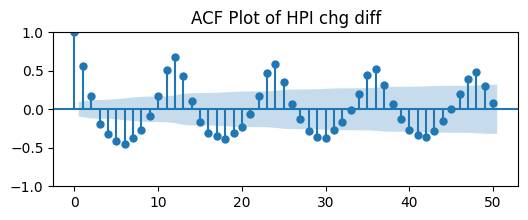

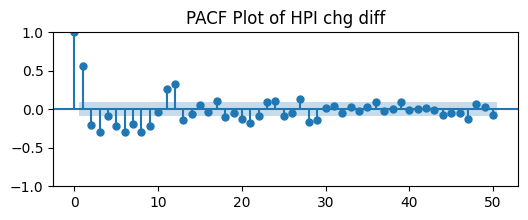

In [9]:
f_acf = plot_acf(target['target_HPI_chg_diff'], lags=50, title='ACF Plot of HPI chg diff')
f_pacf = plot_pacf(target['target_HPI_chg_diff'], lags=50, method='ols', title='PACF Plot of HPI chg diff')
f_acf.set_figheight(2)
f_acf.set_figwidth(6)
f_pacf.set_figheight(2)
f_pacf.set_figwidth(6)
plt.show()

## features

In [10]:
features_lst = []

## time series features
HPI_chg = get_data('CSUSHPINSA', 'HPI_chg', target.index, chg)
features_lst.append(HPI_chg)
features_lst.append(ewma(HPI_chg, col_name='HPI_chg_ewma'))

## population
features_lst.append(get_data('SPPOPGROWUSA', 'pop_growth', target.index))
features_lst.append(get_data('SPDYNTFRTINUSA', 'fertility', target.index))
features_lst.append(get_data('LFWA64TTUSM647S', 'working_pop_growth', target.index, chg))


## economy, production
features_lst.append(get_data('GDP', 'GDP_chg', target.index, chg))
features_lst.append(get_data('VAPGDPFI', 'GDP_Real_Estate_chg', target.index, chg))


## employment, income, asset
features_lst.append(get_data('UNRATE', 'unemploy_rate', target.index))
features_lst.append(get_data('NROU', 'noncyclical_unemploy_rate_chg', target.index, chg))
features_lst.append(get_data('EMRATIO', 'employ_pop_ratio', target.index))
features_lst.append(get_data('GDINOS', 'GDI_chg', target.index, chg))
features_lst.append(get_data('BOGZ1FL192090005Q', 'household_net_worth_growth', target.index, chg))
features_lst.append(get_data('OEHRENWBSHNO', 'household_equity_real_estate_growth', target.index, chg))


## interest rate and loan
features_lst.append(get_data('REAINTRATREARAT10Y', 'real_IR_10Y', target.index))
features_lst.append(get_data('REAINTRATREARAT10Y', 'real_IR_10Y_chg', target.index, chg))
features_lst.append(get_data('REAINTRATREARAT1YE', 'real_IR_1Y', target.index))
features_lst.append(get_data('REAINTRATREARAT1YE', 'real_IR_1Y_chg', target.index, chg))
Mortgage_Rate_30Y_ewma6 = get_data('MORTGAGE30US', 'mortgage_rate_30Y_ewma6', target.index, partial(ewma, hzn=6))
features_lst.append(chg(Mortgage_Rate_30Y_ewma6, col_name='mortgage_rate_30Y_ewma6_chg'))
features_lst.append(Mortgage_Rate_30Y_ewma6)
DFF_ewma_5 = get_data('DFF', 'Fed_effective_rate_ewma5', target.index, partial(ewma, hzn=5))
features_lst.append(DFF_ewma_5)
features_lst.append(chg(DFF_ewma_5, col_name='Fed_effective_rate_ewma5_chg'))
features_lst.append(get_data('INTDSRUSM193N', 'discnted_rate', target.index))
features_lst.append(get_data('INTDSRUSM193N', 'discnted_rate_chg', target.index, chg))

features_lst.append(get_data('MDSP', 'mortgage_income_ratio', target.index))
Real_Estate_Loan_ewma = get_data('RHEACBW027SBOG', 'real_estate_loan_ewma', target.index, partial(ewma, hzn=2))
features_lst.append(chg(Real_Estate_Loan_ewma))
features_lst.append(get_data('BOGZ1FL893065125Q', 'home_equity_loan', target.index))
features_lst.append(get_data('BOGZ1FL893065125Q', 'home_equity_loan_chg', target.index, chg))
features_lst.append(get_data('TOTALSL', 'credit_securitized_chg', target.index, chg))


## delinquency rate and default risk
features_lst.append(get_data('DRCRELEXFACBS', 'delinquency_rate_real_estate', target.index))
features_lst.append(get_data('DRCRELEXFACBS', 'delinquency_rate_real_estate_chg', target.index, chg))
features_lst.append(get_data('TEDRATE', 'TED_spread', target.index))


## equity market and commodity market
features_lst.append(get_data('WILL5000PR', 'Wilshire_5000_chg', target.index, chg))
features_lst.append(get_data('VIXCLS', 'VIX', target.index))
features_lst.append(get_data('VIXCLS', 'VIX_chg', target.index, chg))
features_lst.append(get_data('PCU2122212122210', 'gold_chg', target.index, chg))


## real estate related investment
features_lst.append(get_data('ABCOMP', 'ABCOMP', target.index))
ABCOMP_chg = get_data('ABCOMP', 'ABCOMP_chg', target.index)
real_estate_trust_growth = get_data('WILLREITIND', 'real_estate_trust_growth', target.index)
real_estate_security_growth = get_data('WILLRESIPR', 'real_estate_security_growth', target.index)
features_lst.append(get_data('ABCOMP', 'ABCOMP_chg', target.index, chg))
features_lst.append(get_data('WILLREITIND', 'real_estate_trust_growth', target.index, chg))
features_lst.append(get_data('WILLRESIPR', 'real_estate_security_growth', target.index, chg))


## inflation, price index, expenditure
features_lst.append(get_data('FPCPITOTLZGUSA', 'inflation', target.index))
features_lst.append(get_data('EXPINF1YR', 'inflation_exp_1Y', target.index))
features_lst.append(get_data('EXPINF1YR', 'inflation_exp_1Y_vol', target.index, partial(ewm_std, hzn=3)))
features_lst.append(get_data('CORESTICKM159SFRBATL', 'CPI', target.index))
features_lst.append(get_data('CORESTICKM159SFRBATL', 'CPI_growth', target.index, chg))
features_lst.append(get_data('CXUHHOPERLB0502M', 'expenditures_growth', target.index, chg))
features_lst.append(get_data('PCUAWHLTRAWHLTR', 'PPI_wholesale', target.index))
features_lst.append(get_data('PCUAWHLTRAWHLTR', 'PPI_wholesale_growth', target.index, chg))
features_lst.append(get_data('MSPUS', 'median_house_price_chg', target.index, chg))


## money supply
features_lst.append(get_data('WM2NS', 'M2_growth', target.index, chg))
WM2NS_ewma_1 = get_data('WM2NS', 'M2_ewma', target.index, ewma)
features_lst.append(chg(WM2NS_ewma_1, col_name='M2_ewma_growth'))

## house supply
features_lst.append(get_data('PCU33712133712112', 'PPI_furniture_growth', target.index, chg))
features_lst.append(get_data('WPUSI012011', 'PPI_construction_growth', target.index, chg))
features_lst.append(get_data('PCU32733273', 'PPI_concrete_growth', target.index, chg))
features_lst.append(get_data('PERMIT', 'PERMIT', target.index))
features_lst.append(get_data('HOUST', 'new_house', target.index))
features_lst.append(get_data('ETOTALUSQ176N', 'house_inventory_chg', target.index, chg))
features_lst.append(get_data('ACTLISCOUUS', 'house_inventory_cnt', target.index))
features_lst.append(get_data('ACTLISCOUUS', 'house_inventory_cnt_chg', target.index, chg))


## rental
features_lst.append(get_data('RRVRUSQ156N', 'rental_vacancy', target.index))
features_lst.append(get_data('CUSR0000SEHA', 'rent_growth', target.index, chg))
features_lst.append(get_data('ERNTOCCUSQ176N', 'renter_occupied_housing_growth', target.index, chg))

In [11]:
features = pd.concat(features_lst, axis=1)

# first order difference features
features[[i+'_diff' for i in features.columns]] = features.diff(1)
features['HPI_chg_diff_std'] = features['HPI_chg_diff'].rolling(24).std()
features['HPI_chg_diff_ewma'] = ewma(features['HPI_chg_diff'], hzn=1)
features['HPI_chg_diff_ewm_std'] = ewm_std(features['HPI_chg_diff'], hzn=3)

# seasonality features
features['month'] = features.index.month
features['quarter'] = features['month']%4

Correlation between features and true label

In [12]:
data = build_XY(features, target)
corr = data.corr()['target_HPI_chg_diff']
corr = corr.loc[features.columns].sort_values()
corr_show = corr[np.abs(corr)>0.10]
fig = px.bar(corr_show, x=corr_show.index, y=corr_show)
fig.update_layout(font=dict(size=16,), xaxis_title='features', yaxis_title='corr')
fig.show()

correlation between features

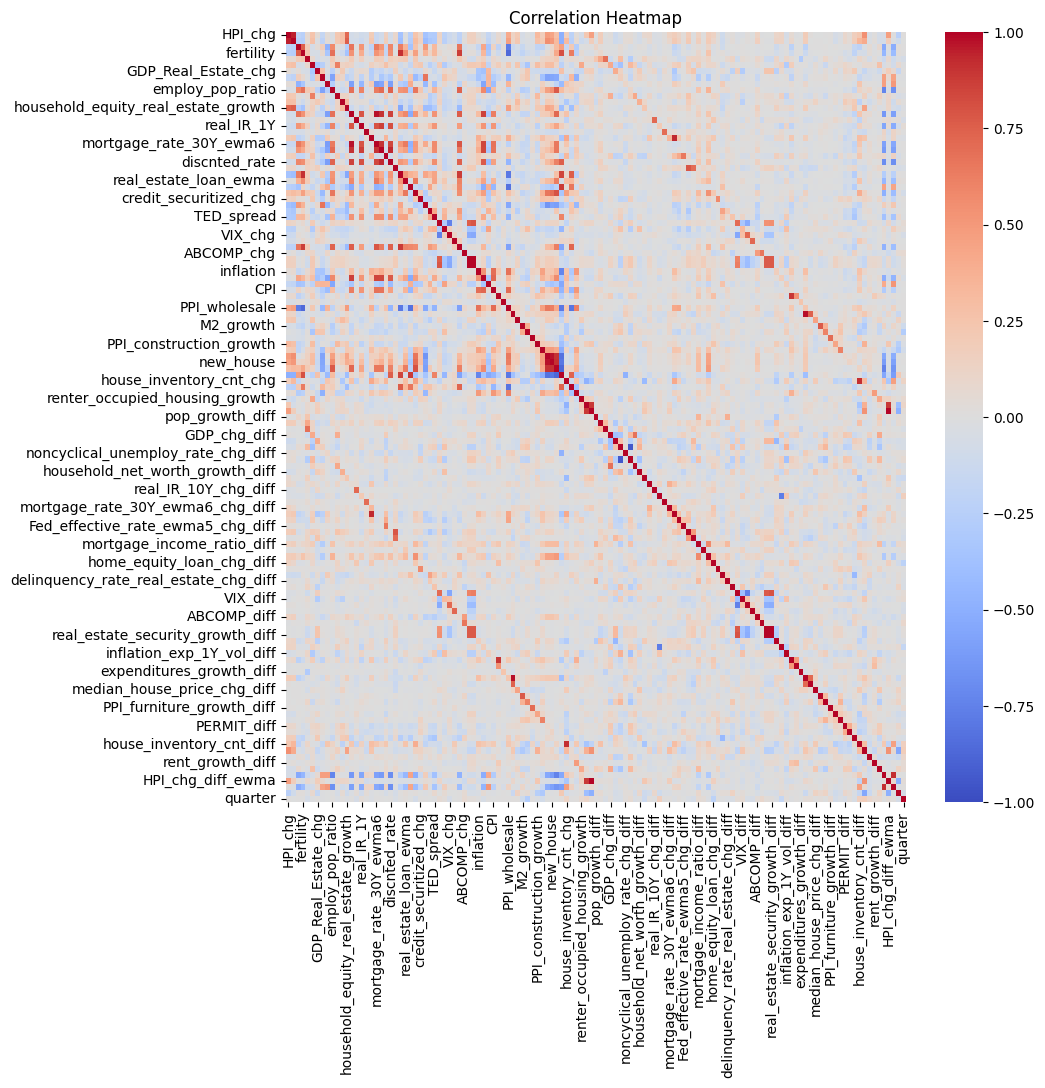

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(features.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## models


### benchmark model
**predicted HPI_chg = 0**

In [14]:
pred_index = data[60:].index
pred_HPI_chg_benchmark = pd.Series([0]*len(pred_index), index=pred_index)
performance(pred_HPI_chg_benchmark, 'benchmark', False)

,MAE,RMSE,Corr
benchmark,0.006422,0.008221,NaN


### Lag 1 model
**predicted delta HPI_chg = 0**

**predicted HPI_chg = today's HPI_chg + predicted delta HPI_chg = today's HPI_chg**

In [15]:
pred_index = data[60:].index
pred_lag1 = pd.Series([0]*len(pred_index), index=pred_index)
performance(pred_lag1, 'lag1', True)

,MAE,RMSE,Corr
lag1,0.00223,0.003249,0.901127


### Ridge
**predicted delta HPI_chg = Ridge's prediction**

**predicted HPI_chg = today's HPI_chg + predicted delta HPI_chg**

In [16]:
data = build_XY(features, target)
data = one_hot(data, ['month', 'quarter'])
feature_names = [i for i in data.columns if not i.startswith('target')]

preds_Ridge = []

for train_x, train_y, test_x, test_y in rolling_windows(data[feature_names], data[['target_HPI_chg_diff']], 60, 180, 1):
    # train model
    train_x, test_x = remove_outliers(train_x, test_x)
    train_x, test_x = fill_abnormal_by_mean(train_x, test_x)
    train_x, test_x = conduct_PCA(train_x, test_x, 0.99)
    model = train_OLS(train_x, train_y, True)

    # feature selection
    add_const, selected_features = linear_model_feature_selection(model)
    train_x = train_x[selected_features]
    test_x = test_x[selected_features]

    # fit model again
    model = train_OLS_reg(train_x, train_y, add_const, 0.15)

    # test model
    pred = predict_OLS(model, test_x, add_const)
    preds_Ridge.append(pred)

preds_Ridge = pd.concat(preds_Ridge)

In [17]:
performance(preds_Ridge, 'Ridge', True)

,MAE,RMSE,Corr
Ridge,0.00156,0.002402,0.948313


### LightGBM
**predicted delta HPI_chg = LightGBM's prediction**

**predicted HPI_chg = today's HPI_chg + predicted delta HPI_chg**

In [18]:
lgb_params = get_lgbm_params()
data = build_XY(features, target)
feature_names = [i for i in data.columns if not i.startswith('target')]

preds_lgbm = []
rmse_increases = []

for train_x, train_y, valid_x, valid_y, test_x, test_y in rolling_windows_wvalid(data[feature_names], data['target_HPI_chg_diff'], 60, 440, 0.2, 1):
    # train model
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(train_x,
              train_y,
              eval_set=[(valid_x, valid_y)],
              callbacks=[
                  lgb.callback.early_stopping(stopping_rounds=10),
                  lgb.callback.log_evaluation(period=100),
            ],)


    # feature performance
    rmse_increase = calc_rmse_gain(model, valid_x, valid_y)
    rmse_increases.append(rmse_increase)


    # fit model again
    lgb_params['n_estimators'] = int(model.best_iteration_ * 1.2)
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(pd.concat([train_x, valid_x]),
              pd.concat([train_y, valid_y]),
              callbacks=[
                  lgb.callback.log_evaluation(period=100),
            ],)
    pred = pd.Series(model.predict(test_x), index=test_x.index)
    preds_lgbm.append(pred)

preds_lgbm = pd.concat(preds_lgbm)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's l2: 3.61608e-06
[200]	valid_0's l2: 3.32262e-06
[300]	valid_0's l2: 3.09922e-06
Did not meet early stopping. Best iteration is:
[299]	valid_0's l2: 3.09678e-06
Training until validation scores don't improve for 10 rounds
[100]	valid_0's l2: 3.71109e-06
[200]	valid_0's l2: 3.3323e-06
[300]	valid_0's l2: 3.03221e-06
Early stopping, best iteration is:
[339]	valid_0's l2: 2.93102e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's l2: 2.9638e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 2.40177e-06
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's l2: 2.66605e-06
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's l2: 2.49789e-06
Trainin

In [19]:
performance(preds_lgbm, 'LightGBM', True)

,MAE,RMSE,Corr
LightGBM,0.001488,0.0023,0.953051


### ensemble model
**predicted delta HPI_chg = LightGBM's prediction + Ridge's prediction**

**predicted HPI_chg = today's HPI_chg + predicted delta HPI_chg**

In [20]:
preds = 0.5*(preds_lgbm+preds_Ridge)
performance(preds, 'Ensemble: Ridge + LightGBM', True)

,MAE,RMSE,Corr
Ensemble: Ridge + LightGBM,0.001449,0.002273,0.953691


## Feature Analysis

**Top 20 features with highest SHAP**

In [21]:
avg_rmse_increases = pd.concat(rmse_increases, axis=1).mean(axis=1).sort_values().tail(20)
fig = px.bar(avg_rmse_increases, x=avg_rmse_increases.index, y=avg_rmse_increases)
fig.update_layout(height=400, width=1000,  font_size=16)
fig.show()

**Top 20 features with highest SHAP (exclude feature 'month')**

In [22]:
avg_rmse_increases_wo_month = avg_rmse_increases.drop(index='month')
fig = px.bar(avg_rmse_increases_wo_month, x=avg_rmse_increases_wo_month.index, y=avg_rmse_increases_wo_month)
fig.update_layout(height=400, width=1000,  font_size=16, xaxis_title='features', yaxis_title='RMSE Gain')
fig.show()